## Import Libraries

In [1]:
!pip install awswrangler

In [2]:
import awswrangler as wr
import boto3

mybucket = 'dlocal-eu1-office-live-sagemaker-aons'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import decimal
import math

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

## Upload Data Base

In [4]:
query = '''

select
    ml.case_id,
    ca.bin,
    ca.brand,
    ca.category,
    rc.usd_amount,
    rc.online_verdict,
    cc.result,
    case
        when rc.online_verdict_reason like '%Positive%'then 1
        else 0
    end as flag_PU,
    case
        when id_chargeback is not null then 1
        else 0
    end as flag_cbk,
    ml.pred_score

from risk.risk_risk_case rc

join "dlocal-eu1-office-live-machine-learning"."saas_test_dataset_new_merchants_20211004" ml
    on ml.case_id = rc.case_id
    
left join risk.risk_card ca
    on ca.card_id = rc.card_id

left join risk.risk_risk_case_collect cc
    on cc.case_id = rc.case_id

left join default.merchant_data_pf md
    on rc.merchant_reference = md.merchant_reference
    and rc.country_code = md.country_code

left join dl_db_master.unipay_chargebacks cbk 
    on rc.ticket_id = cbk.id_boleto
    and cc.result='ACCEPT'

where rc.merchant_reference = '30630'
    and rc.operation_type in('WITH_CVV', 'WITHOUT_CVV', 'TOKEN')
    and rc.created_date between date '2021-04-17' and date '2021-09-15'

'''

In [5]:
%%time

df_original = wr.athena.read_sql_query(
    sql=query,
    database = 'risk',
    ctas_approach=False,
    encryption = 'SSE_KMS',
    kms_key = 'arn:aws:kms:eu-west-1:671054319719:key/38274908-aebb-4807-8d53-bb6d7a475090',
    workgroup = 'dlocal-eu1-office-live-sagemaker-workgroup',
    s3_output = 's3://dlocal-eu1-office-live-sagemaker-aons/dev'
)

CPU times: user 9.81 s, sys: 647 ms, total: 10.5 s
Wall time: 39.3 s


In [6]:
df_original['case_id'] = df_original.case_id.astype(str)

print('shape --->', df_original.shape)
print('')
print(df_original.info())

shape ---> (1818506, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818506 entries, 0 to 1818505
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   case_id         object 
 1   bin             string 
 2   brand           string 
 3   category        string 
 4   usd_amount      object 
 5   online_verdict  string 
 6   result          string 
 7   flag_PU         Int32  
 8   flag_cbk        Int32  
 9   pred_score      float32
dtypes: Int32(2), float32(1), object(2), string(5)
memory usage: 121.4+ MB
None


In [7]:
df_original.sample(10)

,case_id,bin,brand,category,usd_amount,online_verdict,result,flag_PU,flag_cbk,pred_score
962339,910314004,511781,MC,GOLD,6.64,ACCEPT,ACCEPT,1,0,0.14
1106206,770206038,512215,MC,BLACK,6.84,ACCEPT,ACCEPT,0,0,0.11
123773,877571287,550209,MC,GOLD,6.67,REJECT,REJECT,0,0,622.46
669293,910424544,545377,MC,<NA>,121.46,ACCEPT,REJECT,0,0,738.31
457016,653374007,553636,MC,BLACK,55.30,ACCEPT,ACCEPT,0,0,750.04
430592,679116127,550209,MC,GOLD,6.91,ACCEPT,ACCEPT,0,0,0.03
1689921,657038872,435087,VI,CORPORATE T&E,123.72,ACCEPT,REJECT,0,0,0.04
1758642,629883363,417401,VI,CLASSIC,6.48,ACCEPT,ACCEPT,0,0,773.49
998624,572730481,550209,MC,GOLD,6.50,ACCEPT,REJECT,0,0,508.08
710100,737243305,530599,MC,GOLD,7.05,ACCEPT,ACCEPT,0,0,793.69


In [8]:
df_original.value_counts('online_verdict')

online_verdict
ACCEPT    1780332
REJECT      38143
dtype: int64

In [9]:
df_original.value_counts('result')

result
REJECT       1025459
ACCEPT        788766
AUTHORIZE       4257
dtype: int64

In [10]:
df_original.value_counts('flag_cbk')

flag_cbk
0    1814192
1       4314
dtype: int64

In [11]:
df_original.value_counts('flag_PU')

flag_PU
0    1411494
1     407012
dtype: int64

## Cast usd_amount

In [12]:
df_original.dtypes

case_id            object
bin                string
brand              string
category           string
usd_amount         object
online_verdict     string
result             string
flag_PU             Int32
flag_cbk            Int32
pred_score        float32
dtype: object

In [13]:
df_original=df_original.astype({'usd_amount': 'float32'})

In [14]:
df_original.dtypes

case_id            object
bin                string
brand              string
category           string
usd_amount        float32
online_verdict     string
result             string
flag_PU             Int32
flag_cbk            Int32
pred_score        float32
dtype: object

## Score Ranges

In [15]:
df_original.columns

Index(['case_id', 'bin', 'brand', 'category', 'usd_amount', 'online_verdict',
       'result', 'flag_PU', 'flag_cbk', 'pred_score'],
      dtype='object')

In [16]:
df = df_original[['case_id', 'bin', 'brand', 'category', 'usd_amount', 'online_verdict',
       'result', 'flag_PU', 'flag_cbk', 'pred_score']]

In [17]:
def agrupar_score_inhouse():
    
    values_list_inhouse = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 
                           500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

    conditions_inhouse = []

    for i in values_list_inhouse:
        if i == 0:
            condicion = (df['pred_score'] == 0)
            conditions_inhouse.append(condicion)
        else:
            condicion = (df['pred_score'] < i)
            conditions_inhouse.append(condicion)
            
    df['score_group'] = np.select(conditions_inhouse, values_list_inhouse)
    
agrupar_score_inhouse()

In [18]:
df.head()

,case_id,bin,brand,category,usd_amount,online_verdict,result,flag_PU,flag_cbk,pred_score,score_group
0,846839967,553636,MC,BLACK,6.69,ACCEPT,REJECT,0,0,0.10,25
1,693420434,498453,VI,CLASSIC,6.79,ACCEPT,ACCEPT,0,0,872.41,875
2,942172069,550209,MC,GOLD,1.85,ACCEPT,REJECT,1,0,166.72,175
3,758894366,550209,MC,GOLD,72.94,ACCEPT,ACCEPT,0,0,0.15,25
4,570189362,550209,MC,GOLD,6.50,ACCEPT,REJECT,0,0,503.68,525


## Filter Positive Users

In [19]:
df=df[df['flag_PU']==0]
df.value_counts('flag_PU')

flag_PU
0    1411494
dtype: int64

In [20]:
df.drop(columns=['flag_PU'], inplace=True)

In [21]:
df.sample(5)

,case_id,bin,brand,category,usd_amount,online_verdict,result,flag_cbk,pred_score,score_group
1761045,850532518,535081,MC,PLATINUM,13.43,ACCEPT,ACCEPT,0,0.15,25
622305,750188691,515590,MC,PLATINUM,1.00,ACCEPT,REJECT,0,184.59,200
1023911,1025871749,417401,VI,CLASSIC,6.63,ACCEPT,ACCEPT,0,0.15,25
1318637,930027759,417401,VI,CLASSIC,6.57,ACCEPT,ACCEPT,0,0.16,25
1063113,692249506,550209,MC,GOLD,6.79,ACCEPT,REJECT,0,614.00,625


## Filter dlocal REJECT

In [22]:
df_1=df[df['online_verdict']=='ACCEPT']
df_1.value_counts('online_verdict')

online_verdict
ACCEPT    1373320
dtype: int64

In [23]:
df.drop(columns=['online_verdict'], inplace=True)

In [24]:
df.columns

Index(['case_id', 'bin', 'brand', 'category', 'usd_amount', 'result',
       'flag_cbk', 'pred_score', 'score_group'],
      dtype='object')

## Pivote Table Result

In [25]:
df_1=df[['score_group','result','usd_amount']]

In [26]:
df_1.head(4)

,score_group,result,usd_amount
0,25,REJECT,6.69
1,875,ACCEPT,6.79
3,25,ACCEPT,72.94
4,525,REJECT,6.50


In [27]:
table = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [28]:
table.head(4)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"3,134,057.50","9,780.90","2,899,557.25"
50,610.81,4.62,"2,886.21"
75,"1,016.55",15.45,"6,134.04"
100,"1,973.96",47.06,"12,316.74"


## Graphic Score vs Fianl Result

<AxesSubplot:title={'center':'Scores vs App Fianl'}, xlabel='score_group', ylabel='USD [MM]'>

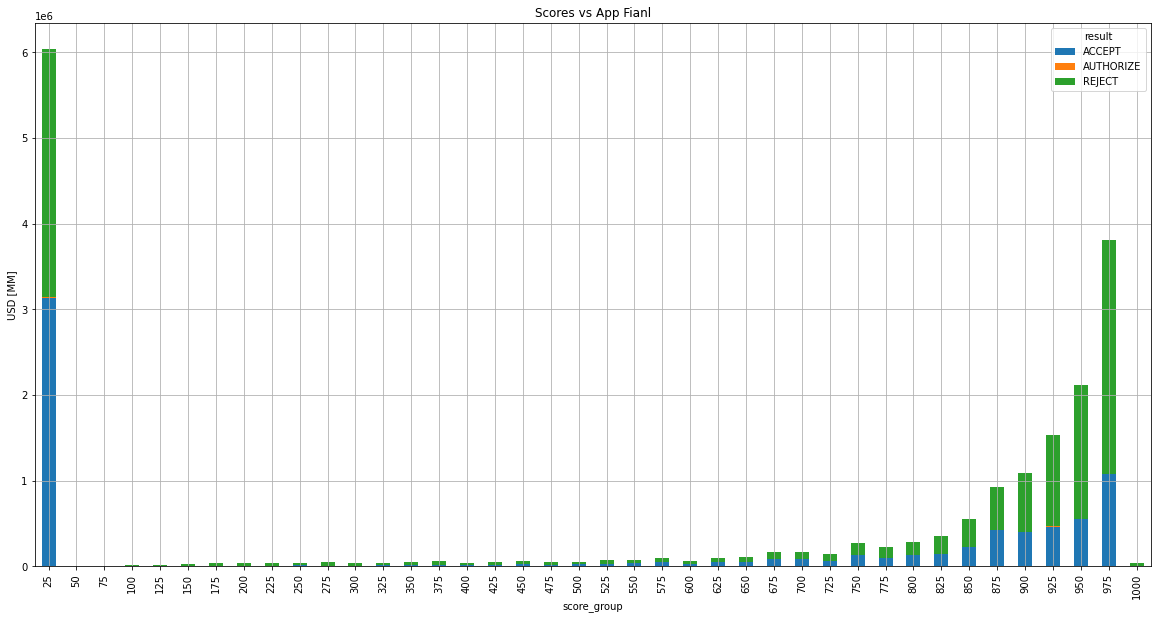

In [29]:
table.plot(kind='bar',
        title = 'Scores vs App Fianl',
        ylabel = 'USD [MM]',
        figsize = (20,10),
        grid = True,
        stacked = True)

## Pivote Table Brand

In [65]:
df_1=df[['brand','result','usd_amount']]

In [66]:
df_1.head(3)

,brand,result,usd_amount
0,MC,REJECT,6.69
1,VI,ACCEPT,6.79
3,MC,ACCEPT,72.94


In [67]:
table = pd.pivot_table(df_1, values='usd_amount', index=['brand'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [68]:
table.head(4)

result,ACCEPT,AUTHORIZE,REJECT
brand,,,
AE,"50,835.25",185.09,"53,874.31"
EL,"93,598.30",375.43,"193,867.34"
HI,211.32,0.00,"2,584.18"
MC,"4,975,834.00","18,896.54","7,643,345.50"


<AxesSubplot:title={'center':'App Final vs Brand'}, xlabel='brand', ylabel='USD [MM]'>

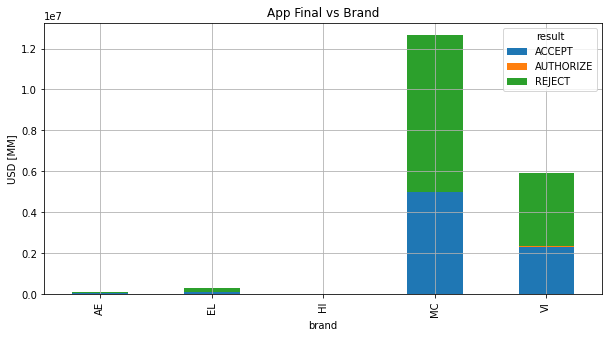

In [70]:
table.plot(kind='bar',
        title = 'App Final vs Brand',
        ylabel = 'USD [MM]',
        figsize = (10,5),
        grid = True,
        stacked = True)

## Pivote Table Category

In [30]:
df_1=df[['category','result','usd_amount']]

In [31]:
df_1.head(3)

,category,result,usd_amount
0,BLACK,REJECT,6.69
1,CLASSIC,ACCEPT,6.79
3,GOLD,ACCEPT,72.94
4,GOLD,REJECT,6.50


In [32]:
table = pd.pivot_table(df_1, values='usd_amount', index=['category'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [33]:
table.head(4)

result,ACCEPT,AUTHORIZE,REJECT
category,,,
ACQUIRER ONLY,0.00,0.00,50.94
ALIMENTACAO,0.00,0.00,1.15
B2B,0.00,0.00,6.78
BASIC,0.00,0.00,2.31


## Graphic Category vs Final Result

<AxesSubplot:title={'center':'App Final vs Category'}, xlabel='category', ylabel='USD [MM]'>

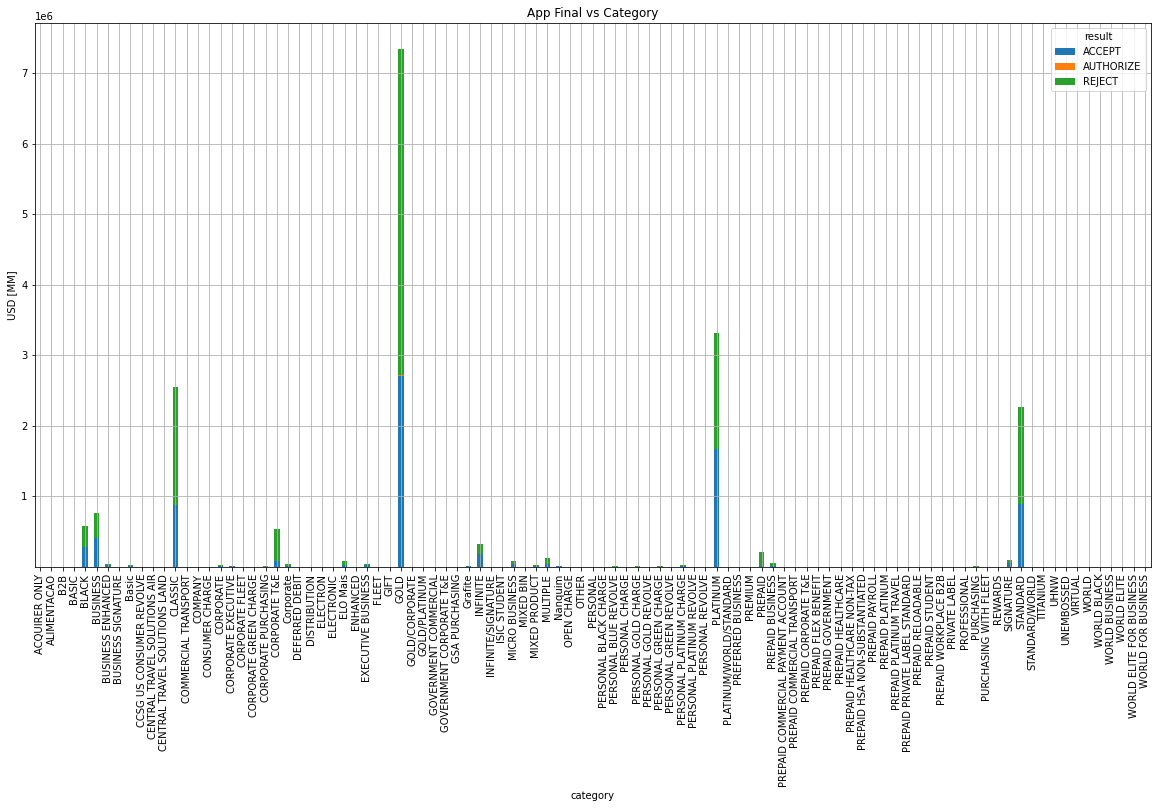

In [34]:
table.plot(kind='bar',
        title = 'App Final vs Category',
        ylabel = 'USD [MM]',
        figsize = (20,10),
        grid = True,
        stacked = True)

## Filter Classic Cards

In [59]:
df.columns

Index(['case_id', 'bin', 'brand', 'category', 'usd_amount', 'result',
       'flag_cbk', 'pred_score', 'score_group'],
      dtype='object')

In [36]:
df_1=df[df['category']=='CLASSIC']
df_1.value_counts('category')

category
CLASSIC    189507
dtype: int64

In [37]:
df_1=df_1[['score_group','result','usd_amount']]

In [38]:
df_1.head(3)

,score_group,result,usd_amount
1,875,ACCEPT,6.79
7,850,REJECT,6.69
14,875,ACCEPT,6.84


In [39]:
table = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [40]:
table.head(3)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"377,102.84","1,171.85","414,058.03"
50,21.22,0.00,400.82
75,37.18,3.45,"1,229.14"


<AxesSubplot:title={'center':'Score vs Classic'}, xlabel='score_group', ylabel='USD'>

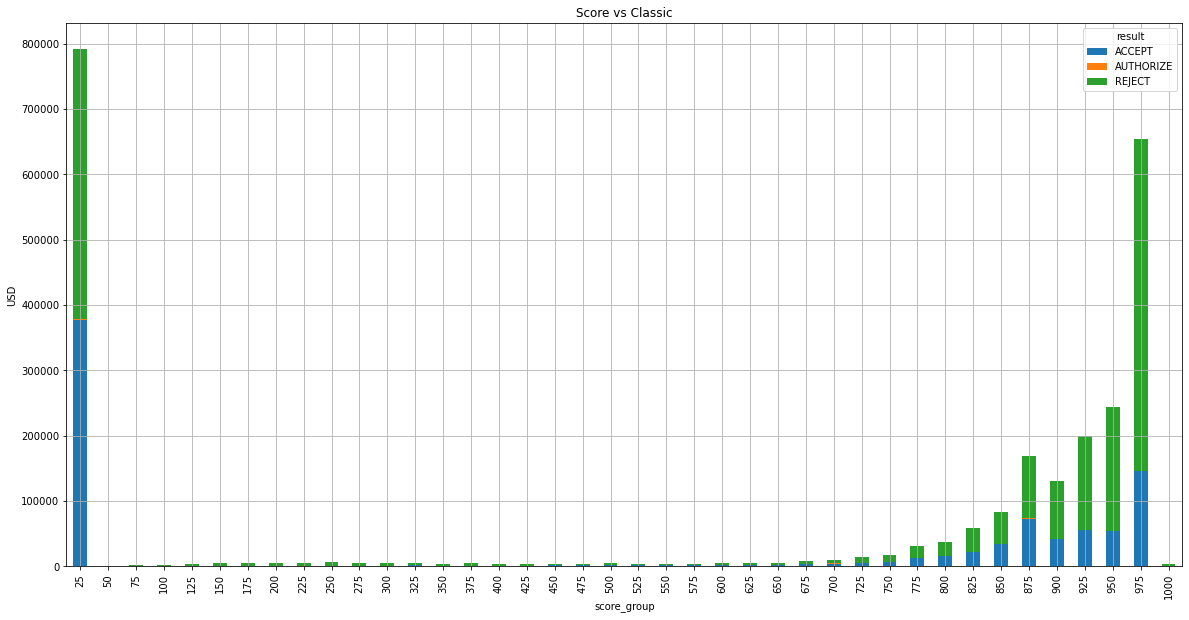

In [41]:
table.plot(kind='bar',
        title = 'Score vs Classic',
        ylabel = 'USD',
        figsize = (20,10),
        grid = True,
        stacked = True)

## Filter Gold Cards

In [42]:
df_1=df[df['category']=='GOLD']
df_1.value_counts('category')

category
GOLD    589195
dtype: int64

In [43]:
df_1=df_1[['score_group','result','usd_amount']]

In [44]:
table = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [45]:
table.head(3)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"1,159,979.00","3,890.91","1,236,840.25"
50,323.45,1.15,"1,273.64"
75,496.58,5.54,"2,372.86"


<AxesSubplot:title={'center':'Score vs Gold'}, xlabel='score_group', ylabel='USD [MM]'>

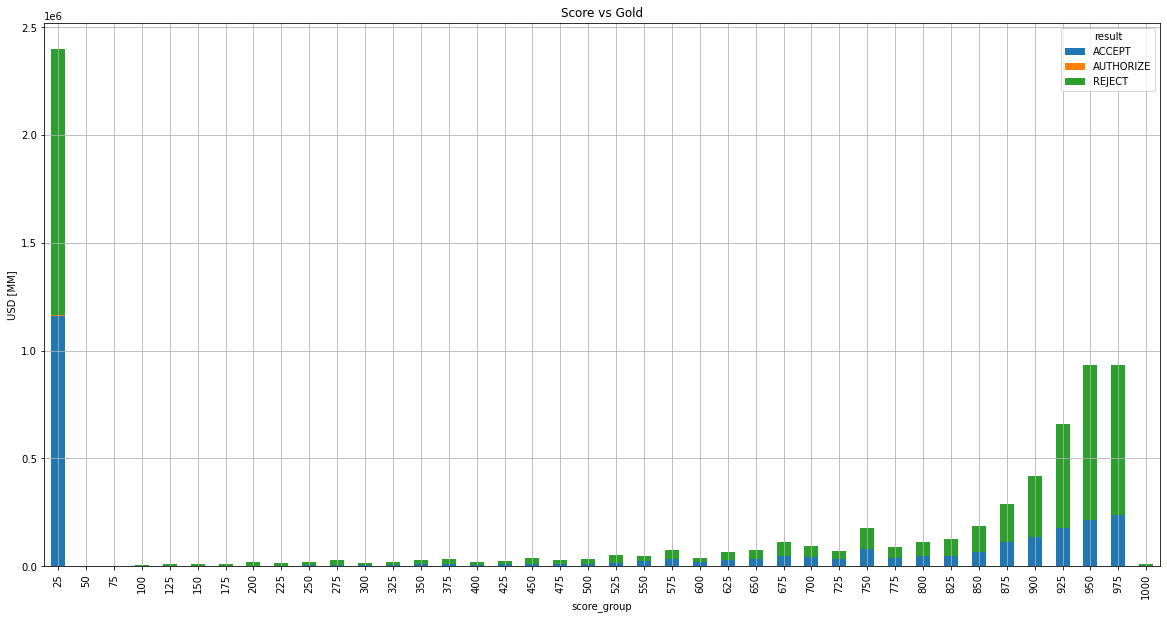

In [46]:
table.plot(kind='bar',
        title = 'Score vs Gold',
        ylabel = 'USD [MM]',
        figsize = (20,10),
        grid = True,
        stacked = True)

## Filter Standard Cards

In [47]:
df_1=df[df['category']=='STANDARD']
df_1.value_counts('category')

category
STANDARD    178748
dtype: int64

In [48]:
df_1=df_1[['score_group','result','usd_amount']]

In [49]:
table = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [50]:
table.head(3)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"387,339.84","1,180.98","346,256.78"
50,7.58,1.15,246.51
75,74.94,0.00,387.82


<AxesSubplot:title={'center':'Score vs Standard'}, xlabel='score_group', ylabel='USD'>

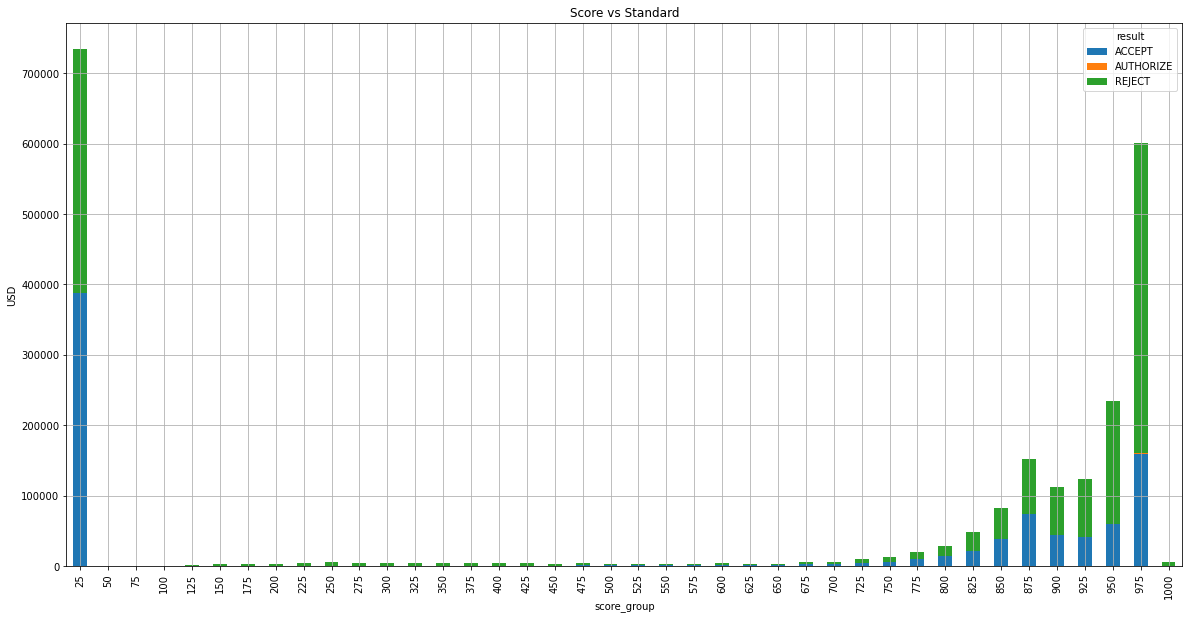

In [51]:
table.plot(kind='bar',
        title = 'Score vs Standard',
        ylabel = 'USD',
        figsize = (20,10),
        grid = True,
        stacked = True)

## Filter Corporate T&E Cards

In [52]:
df_1=df[df['category']=='CORPORATE T&E']
df_1.value_counts('category')

category
CORPORATE T&E    39507
dtype: int64

In [53]:
df_1=df_1[['score_group','result','usd_amount']]

In [54]:
table = pd.pivot_table(df_1, values='usd_amount', index=['score_group'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [55]:
table.head(3)

result,ACCEPT,AUTHORIZE,REJECT
score_group,,,
25,"31,021.72",74.07,"117,068.96"
50,1.85,0.00,151.06
75,20.26,4.12,576.46


<AxesSubplot:title={'center':'Score vs Corporate T&E'}, xlabel='score_group', ylabel='USD'>

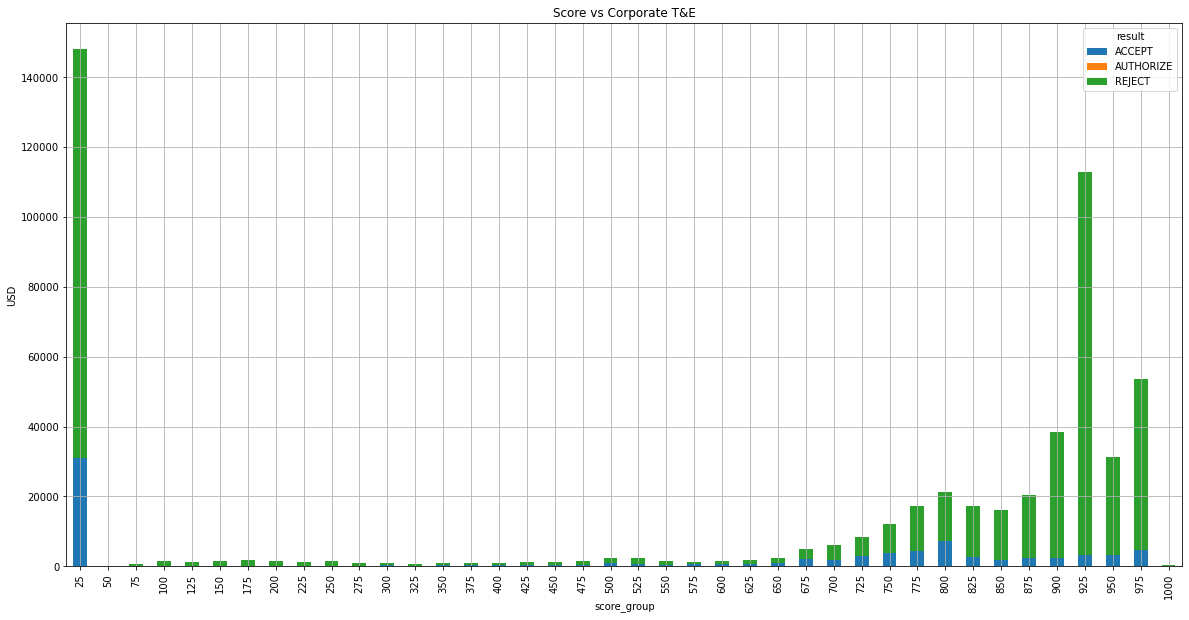

In [57]:
table.plot(kind='bar',
        title = 'Score vs Corporate T&E',
        ylabel = 'USD',
        figsize = (20,10),
        grid = True,
        stacked = True)

## BINs Classic Cards

In [58]:
df.columns

Index(['case_id', 'bin', 'brand', 'category', 'usd_amount', 'result',
       'flag_cbk', 'pred_score', 'score_group'],
      dtype='object')

In [60]:
df_1=df[df['category']=='CLASSIC']
df_1.value_counts('category')

category
CLASSIC    189507
dtype: int64

In [61]:
df_1=df[['bin','result','usd_amount']]

In [62]:
table = pd.pivot_table(df_1, values='usd_amount', index=['bin'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [63]:
table.head(3)

result,ACCEPT,AUTHORIZE,REJECT
bin,,,
222738,0.00,0.00,1.16
222746,0.00,0.00,0.99
222763,"15,884.25",56.40,"34,509.30"


## Pivote Table BIN

In [65]:
df_1=df[['bin','result','usd_amount']]

In [66]:
df_1.head(4)

,bin,result,usd_amount
0,474525,REJECT,1.98
1,544891,REJECT,71.05
2,516306,REJECT,1.18
3,453211,ACCEPT,6.66


In [67]:
table = pd.pivot_table(df_1, values='usd_amount', index=['bin'],
                    columns=['result'], aggfunc=np.sum, fill_value=0)

In [68]:
table.head(4)

result,ACCEPT,AUTHORIZE,REJECT
bin,,,
222738,0.00,0.00,1.16
222746,0.00,0.00,0.99
222763,"15,884.25",56.40,"34,509.30"
222768,0.00,0.00,2.28
